# Introdução

Nesse notebook é realizada a análise preliminar dos dados completos e sua
separação em dados de treinamento e teste. Nessa análise preliminar iremos
fazer diagnósticos da qualidade dos dados e quando necessário ajustá-lo. Isso,
compreende correção do tipo dos dados, avaliação da consistência, análise de
dados faltantes (sem considerar técnicas estatísticas de imputação) e remoção
de dados duplicados.

O segundo objetivo é a separação dos dados em dados de treinamento e teste para
que os modelos de classificação e recomendação possam vir a ter sua capacidade
de generalização validada em etapa futura. 

A nossa base de dados é respectiva a registros de resultados de queries. Estes
são dados úteis para a modelagem do ranqueamento de resultados a partir de uma
query. Porém, para a modelagem da predição de categorias de produtos precisamos
de dados relativos apenas a produtos. Dessa forma, iremos separar os dados em
dois datasets, e em seguida separar cada um destes em treinamento e testes,
totalizando ao todo 4 datasets. Para o caso dos dados de produtos, precisamos
garantir ainda que tanto os dados de treinamento quanto os de teste possuam as
categorias representadas corretamente.

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

# Carregamento dos dados

In [3]:
df = pd.read_csv(r"..\data\complete_dataset.csv")
df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [4]:
df.shape

(38507, 15)

Os dados foram carregados corretamente e ao todo temos 38.507 registro com
15 atributos.

# Análise preliminar dos dados

## Dados faltantes

In [5]:
df.isna().mean().mul(100).round(2)

product_id            0.00
seller_id             0.00
query                 0.00
search_page           0.00
position              0.00
title                 0.00
concatenated_tags     0.01
creation_date         0.00
price                 0.00
weight                0.15
express_delivery      0.00
minimum_quantity      0.00
view_counts           0.00
order_counts         52.95
category              0.00
dtype: float64

Apenas a coluna `order_counts` possui uma quantidade de dados faltantes
significativa (52,95%). Outras colunas que também possuem dados faltantes são
`weight` (0,01%) e `concatenated_tags` (0,15%), porém estes, em um nível
desprezível.

In [6]:
(df["order_counts"] == 0).any()

False

O fato de não termos nenhum registro de `order_counts` como sendo igual a 0.
Pode ser um indicativo de que caso um item não receba ordens na query, a
observação ficará como `missing`. Supondo que esse realmente seja o caso (o que
parece ser bastante razoável), para sanarmos essa grande quantidade de dados
faltantes em `order_counts` basta preencher dados faltantes dessa coluna com
`0`.

In [7]:
df["order_counts"].fillna(0, inplace=True)
df["order_counts"].isna().any()

False

Como a quantidade de dados faltantes nas outras variáveis é muito pequena,
optou-se por remover as observações que possuam dados faltantes.

In [8]:
df.dropna(inplace=True)

## Verificando o tipo das variáveis

Para simplificar a conformação dos dados vamos tratar variáveis categóricas
como textuais (`object`).

In [9]:
df.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

A primeira variável que será modificada é a `creation_date`. Como não
especificamos no momento do carregamento dos dados qual coluna do dataset
deveria ser parseado para data, esse campo foi carregado como um `object` ao
invés de um `datetime`.

Avaliando as primeiras linhas dessa coluna, vemos que ela aparentemente está
formatada corretamente. Para nos certificarmos que a conversão ocorrerá como
esperado ao invés de deixar que o método de conversão infira o formato da data
esse formato será especificado (`Y-m-d H:M:S`).

In [10]:
df["creation_date"].head()

0    2015-11-14 19:42:12
1    2018-04-04 20:55:07
2    2018-10-13 20:57:07
3    2017-02-27 13:26:03
4    2017-05-09 13:18:38
Name: creation_date, dtype: object

In [11]:
df["creation_date"] = pd.to_datetime(df["creation_date"],
                                     format="%Y-%m-%d %H:%M:%S")
df["creation_date"].head()

0   2015-11-14 19:42:12
1   2018-04-04 20:55:07
2   2018-10-13 20:57:07
3   2017-02-27 13:26:03
4   2017-05-09 13:18:38
Name: creation_date, dtype: datetime64[ns]

Apesar de menor importância outra variável que pode ter seu tipo modificado é
a `order_counts` que antes estava definida como `float`. A variável estava
tipada dessa forma pois possuía registros faltantes entre suas observações.
Como já acabamos com esse problema, faz sentido para esse tipo de dado
convertê-lo para número inteiro.

In [12]:
df["order_counts"] = df["order_counts"].astype("int")
df["order_counts"].head()

0    0
1    0
2    0
3    1
4    0
Name: order_counts, dtype: int32

Por fim, vamos verificar se as variáveis categóricas `express_delivery` e
`category`, possuem entre as suas observações apenas valores referentes às suas
categorias previstas.

In [13]:
# verificando se temos apenas registros com observações iguais às esperadas
# tanto para a variável express_delivery quanto para category
assert set(df["express_delivery"].unique()) == set([1, 0])
cat_list = ["Bebê", "Bijuterias e Jóias", "Decoração",
            "Lembrancinhas", "Papel e Cia", "Outros"]
assert set(df["category"].unique()) == set(cat_list)

Após essa última verificação vemos que ambas as variáveis têm o preenchimento
correto de suas categoriais.

## Eliminando registros duplicados

Nessa etapa vamos remover os registros duplicados. Porém, antes de fazer isso
precisamos definir o que será considerado como um registro duplicado. Para tal,
precisamos antes entender que tipo de registro nós estamos utilizando e para
qual propósito iremos utilizá-lo.

A nossa base de dados é de resultados de queries. Será utilizada para o
treinamento de um modelo de classificação de produtos e outro de recomendação
de produtos. Dado esses dois propósitos distintos podemos ter que separar a
base em duas, cada uma representando um tipo de entidade específico.

Para o primeiro problema teremos que reduzir os dados a dados de produtos,
indexando-os pelo `product_id`. Como estamos utilizando dados de resultados
de queries é esperado que alguns produtos, venham a ser encontrados repetidas
vezes ao longo dos registros. Dessa forma, temos que definir quais dos
registros duplicados iremos eliminar, ou então uma forma de reunir a informação
das duplicadas em uma observação unificada. 

Já para a elaboração do modelo de recomendação nósso tipo de observação é
exatamente aquele que os nossos dados registros, dados de resultados de
queries. Sendo assim, só precisamos verificar se existem observação que são
duplicadas (uma linha inteira). 

Seria esperado que para uma combinação de querie e produto não hajam variações,
o que não é o que observamos. Isso significa que dada uma query um mesmo
produto pode vir a ser listado como resultado mais de uma vez.
Apesar de ser intrigante não é claro que essas variações devam ser eliminadas,
uma vez que variações em quantidade mínima e preço, podem afetar a posição de
um item em um resultado de busca. Sendo assim, podem ser úteis para o nosso
segundo modelo, o ranqueamento de itens a partir de uma query.

### Analisando registros duplicados

Antes de fazer a eliminação dos registros duplicados devemos analisar como
esses registros duplicados podem afetar os dados. Uma forma de avaliar isso,
é primeiro identificando quais colunas possuem as observações unicamente
relacionadas com os identificadores únicos dos registros (dos tipos query e
produto) e em seguida, como as colunas que não são unicamente relacionados
com os identificadores únicos variam por registros duplicados.

Para fazer essa identificação das colunas que variam e não variam com os ids
de registros a função `check_unity` será utilizada. Essa função compara a
quantidade de ids únicos com a quantidade de combinações únicas entre cada
variável e o id. Se ambos os números forem iguais, a variável é associada
unicamente, caso contrário existem variações nessa coluna para um mesmo
id de registro.

In [14]:
def check_unity(df: pd.DataFrame, id_group: list[str]) -> list[str]:
    """Verifica, para cada variável do dataset, quais variáveis são unicamente
    relacionadas com as variáveis que identificam unicamente os registros
    id_group. As variáveis que não se relacionam unicamente são retornadas
    como resultado da função.

    Args:
        df (pd.DataFrame): dataset
        id_group (list[str]): variáveis que combinadas identificam unicamente
        os registros

    Returns:
        list[str]: lista de variáveis que não se relacionam unicamente com
        id_group
    """
    unique_regs = df[id_group].drop_duplicates().shape[0]
    with_variability = list()
    without_variability = list()
    for col in df.columns:
        if col in id_group:
            continue
        else:
            cols_select = id_group + [col]
            cols_id_uniques = df[cols_select].drop_duplicates().shape[0]
            is_equal = unique_regs == cols_id_uniques
            if is_equal:
                without_variability.append(col)
            else:
                with_variability.append(col)
    
    print(f"Únicas em relação a {id_group}")
    print(" | ".join(without_variability))
    print()
    print(f"Com variações em relação a {id_group}")
    print(" | ".join(with_variability))
    return with_variability

A variabilidade em relação a um mesmo identificador único registro das colunas
numéricas será analisada por meio de gráficos de boxplot e histogramas. Para
esses casos o coeficiente de variação será calculado por id, e sua distribuição
será analisada graficamente. Dessa forma avaliaremos a distribuição da não
uniformidade dos dados. Analisando a distribuição como um todo será possível
dimensionar o tamanho dessa variação.

O coeficiente de variação foi escolhido, pois, diferente do desvio padrão, essa
estatística é adimensional, e com isso conseguimos estabelecer comparações
entre variáveis de escalas distintas.

Adicionalmente, será utilizado um gráfico de barras com a distribuição da
quantidade de registros duplicados.

In [15]:
def plot_duplicates_distribution(df: pd.DataFrame,
                                 id_group: list[str],
                                 figsize: tuple[int] = (15, 5)) -> None:
    """Faz o gráfico com a distribuição de contagem de registros por id_group

    Args:
        df (pd.DataFrame): dataset.
        id_group (list[str]): colunas que combinas identificam unicamente os
        registros.
        figsize (tuple[int], optional): tamanho da figura. Defaults to (15, 5).
    """    
    title = "Distribuição da quantidade de duplicados"
    (df.groupby(id_group).
     size().value_counts(normalize=True).sort_index().
     plot(kind="bar", figsize=figsize, title=title))
    plt.xticks(rotation=0)
    plt.show()

def plot_variability_boxplot(duplic_df: pd.DataFrame,
                             figsize: tuple[int] = (15, 8)):
    """Faz o gráfico de boxplot das estatísticas de coeficiente de variação dos
    registros duplicados.

    Args:
        duplic_df (pd.DataFrame): coeficiente de variação de registros
        duplicados
        figsize (tuple[int], optional): tamanho da figura. Defaults to (15, 8).
    """    
    title = "Boxplot dos coeficientes de variação entre registros duplicados"
    duplic_df.boxplot(figsize=figsize)
    plt.title(title)
    plt.show()
    

def plot_variability_histogram(duplic_df: pd.DataFrame,
                               figsize: tuple[int] = (15, 8),
                               layout: tuple[int] = (3, 3),
                               bins: int = 40):
    """Faz o gráfico de histograma das estatísticas de coeficiente de variação
    dos registros duplicados.

    Args:
        duplic_df (pd.DataFrame): coeficiente de variação de registros
        duplicados
        figsize (tuple[int], optional): tamanho da figura. Defaults to (15, 8).
        layout (tuple[int], optional): layout dos subplots. Defaults to (3, 3).
        bins (int, optional): quantidade de bins dos histogramas.
        Defaults to 40.
    """    
    title = "Histograma dos coeficientes de variação entre registros duplicados"
    duplic_df.plot(subplots=True,
                   kind="hist",
                   layout=layout,
                   figsize=figsize,
                   bins=bins,
                   density=True,
                   title=title)
    plt.show()

def var_coef(num_series: pd.Series) -> float:
    """Calcula o coeficiente de variação para uma série

    Args:
        num_series (pd.Series): série de valores numéricos

    Returns:
        float: coeficiente de variação
    """    
    return num_series.std() / num_series.mean()


def plot_variability(df: pd.DataFrame,
                     id_group: list[str],
                     col_list: list[str]) -> None:
    """Executa os gráficos de análise de dados duplicados e variabilidade entre
    registros duplicados

    Args:
        df (pd.DataFrame): dataset.
        id_group (list[str]): combinações de variáveis que identificam.
        unicamente um registro.
        col_list (list[str]): variáveis que terão a variabilidade analisada.
    """    
    
    duplicated_df = (df.loc[df[id_group].
                        duplicated(keep=False)].
                     sort_values(id_group))
    
    plot_duplicates_distribution(df=df, id_group=id_group)
    
    duplicated_var_coef = (duplicated_df.
                           groupby(id_group)[col_list].
                           apply(var_coef).
                           fillna(0))
    
    plot_variability_boxplot(duplic_df=duplicated_var_coef)
    plot_variability_histogram(duplic_df=duplicated_var_coef)

#### Dados de produtos

Como dados de produtos, vamos considerar todos as colunas que não sejam
referentes uma query. Ou seja, a `query` em si executada e o seu resultado
`search_page` e `position`. Todas as outras colunas serão consideradas como
atributos de produto.

In [16]:
product_df = df.drop(columns=["query", "search_page", "position"])
product_df.head()

,product_id,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,0,Decoração
1,15534262,6939286,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,0,Papel e Cia
2,16153119,9835835,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,0,Outros
3,15877252,8071206,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1,Bebê
4,15917108,7200773,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,0,Decoração


In [17]:
id_group = ["product_id"]
product_df.duplicated(id_group).mean()

0.22625952610086614

Como a base é de queries, que relacionam queries com produtos como resultados
da busca, temos uma quantidade considerável de registros duplicados de produto
(22,6%).

In [18]:
selected_cols = check_unity(df=product_df, id_group=id_group)

Únicas em relação a ['product_id']
seller_id | title | concatenated_tags | creation_date | category

Com variações em relação a ['product_id']
price | weight | express_delivery | minimum_quantity | view_counts | order_counts


A grande parte das variáveis que são textuais ou categóricas se identificam
unicamente com `product_id`, a excessão é a `express_delivery`. Todas as outras
variáveis podem apresentar variações para um mesmo produto. Com isso podemos
hipotetizar que as queries aconteçam ao longo do tempo e que no passar desse
tempo tenhamos variações nos produtos. É esperado que os preços possam variar
de modo a incorporar a inflação. Também é possível que vendedores mudem as suas
estratégias e alterem a quantidade de itens enviadas por cada compra, e com isso,
condições de peso, entrega e quantidade mínima também variam. Por fim, com o
tempo a quantidade de pessoas que acessa a página e compra esses produtos
também tende a aumentar.

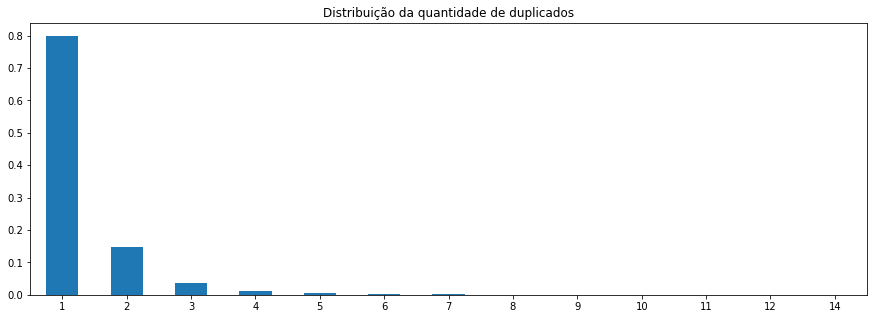

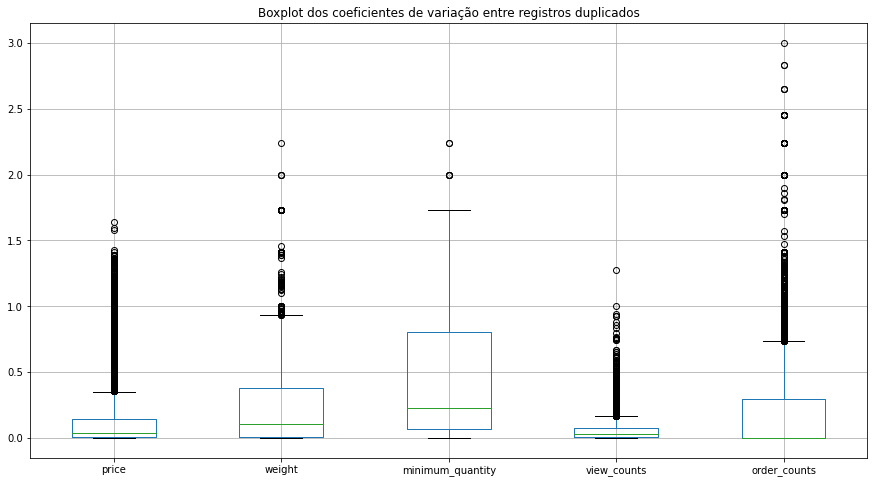

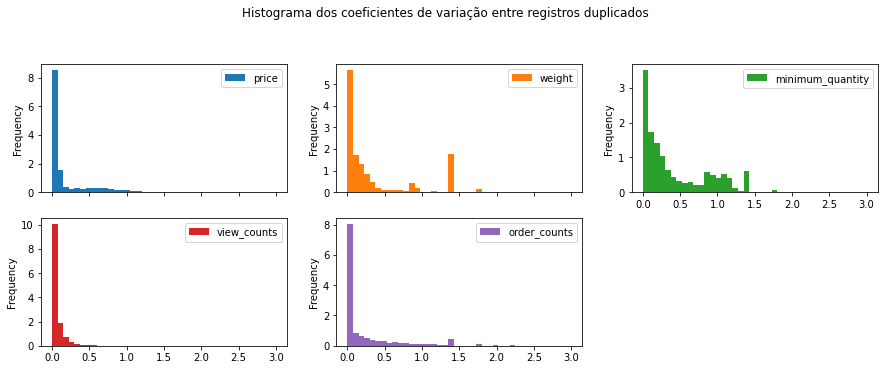

In [19]:
# removendo express_delivery da lista de coluna que variam por produto
selected_cols.pop(2)
# analisando do coeficiente de variação por produto das variáveis que não
# se relacionam unicamente com os produtos
plot_variability(df=product_df, id_group=["product_id"], col_list=selected_cols)

Como podemos observar pela distribuição da frequência dos produtos, vemos que
poucos produtos aparecem mais de uma vez na base, quase 80% dos produtos
aparecem apenas uma vez na base. Um pouco mais de 10%, apenas 2 vezes. Dessa
forma, vemos muito poucos produtos que são retornados por múltiplas queries (o
que deve estar relacionado a uma grande variabilidade nas queries da amostra ou
então um processo de amostragem que já tinha removido parcela de produtos
duplicados).

Considerando os registros duplicados vemos que, entre as variáveis que não estão
relacionadas unicamente com os produtos, possuímos maior variabilidade nos
indicadores de peso, e, principalmente, quantidade mínima no pedido. Ainda,
assim, a maior parte dos registros repetidos possuem variabilidade muito baixa,
bem próxima de zero.

A menor quantidade de registros duplicados e os baixos valores de coeficiente
de variação, são indícios de que a unificação dos registros em torno de medidas
de tendência central podem ocorrer sem que hajam muitos problemas.

#### Dados de queries

Os dados de queries são os dados originais. Estamos considerando como
registros únicos desse tipo de dados as combinações entre produto e queries.
Essa escolha pode ser questionada, principalmente se estamos interessados em
utilizar esses dados para prever ranqueamento de produtos (`position` e/ou
`search_page`) a partir da `query`. Nesses casos, mesmo pequenas variações de
produtos quanto aos seus preços e quantidade mínima podem ser importantes para
definir quais produtos vão estar nas primerias posições do ranqueamento.

Ainda assim, para fins comparativos com o que foi observado no caso dos dados
de produtos vamos prosseguir a análise de dados duplicados utilizando esse par
de identificadores únicos de registros de resultados queries.

In [20]:
id_group = ["product_id", "query"]
selected_cols = check_unity(df=df, id_group=id_group)

Únicas em relação a ['product_id', 'query']
seller_id | title | concatenated_tags | creation_date | category

Com variações em relação a ['product_id', 'query']
search_page | position | price | weight | express_delivery | minimum_quantity | view_counts | order_counts


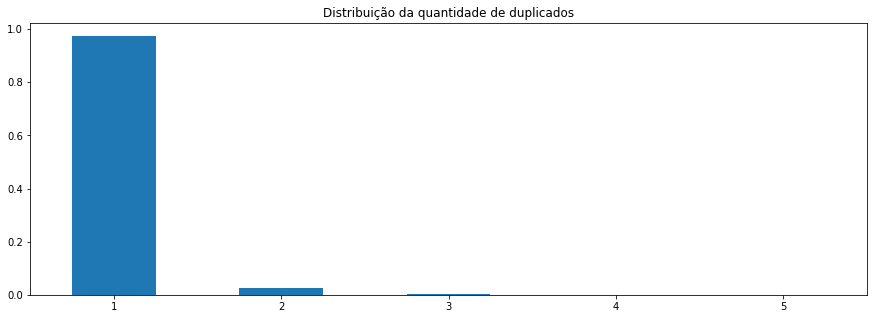

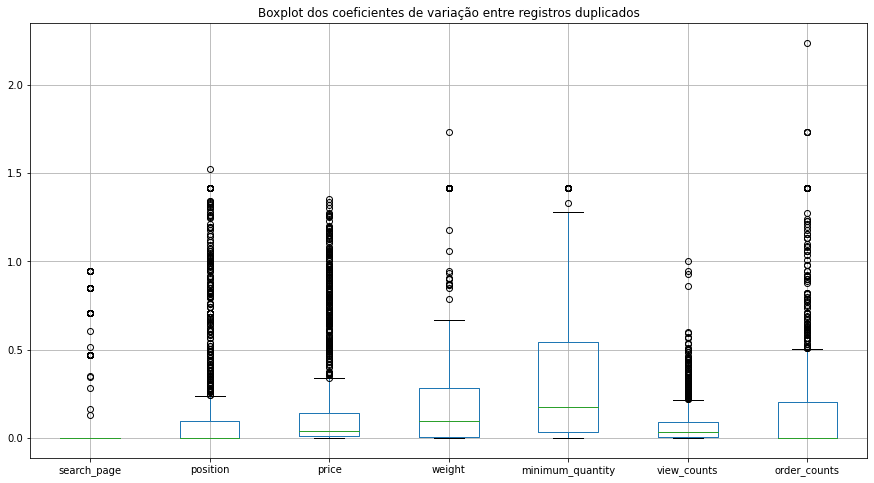

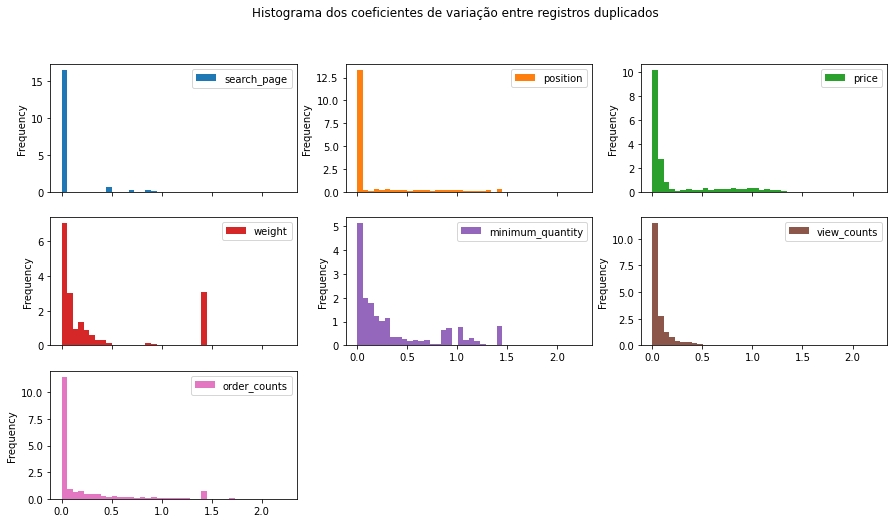

In [21]:
# remoção da express delivery e plotagem dos gráficos de dados duplicados
selected_cols.pop(4)
plot_variability(df=df, id_group=id_group, col_list=selected_cols)

Como era de se esperar, no caso de registros de reultados de queries, temos
uma menor parcela de registros que são duplicados. Quase 100% dos registros
únicos (combinações de produto ou query) aparecem apenas uma vez entre os
registros. Dessa forma, é muito raro, para uma mesma query, vermos um produto
repetido mais de uma vez.

É um pouco intrigante o porque isso ocorre. Mais que o produto aparecer mais
de uma vez, ele aparece com variações de preço, quanidade mínima, peso...
Se isso fosse mais frequente poderíamos começar a questionar o product_id como
identificador único de produtos. Porém esses casos são tão excepcionais que é
possível que sejam relativos a algum problema. Uma possibilidade que talvez
explique isso é caso as informações de uma mesma query possam ser relacionadas
a queries executadas em período distintos. Dessa forma, uma mesma query poderia
estar relacionada múltiplas versões do produto referentes à sua atualização ao
longo do tempo.

Ainda assim, esses dados podem impactar na ordem dos resultados das queries.
Dessa forma, não é tão garantido que a sua remoção não irá prejudicar o
desenvolvimento da solução de recomendação de produtos. Por conta disso, não
iremos remover os dados duplicados de resultados de queries.

Outro ponto interessante é que ao analisar a distribuição dos coeficientes
de variações entre os registros duplicados, vemos que essa distribuição
é ainda mais concentrada em menores valores de coeficienes de variação.
Isso ocorre principalmente para os casos de `search_page` e `position`, o que
pode ser um indicador de que as variações nas outras variáveis não são
correspondidas por variações no ranqueamento dos resultados de queries. Por
fim, da mesma forma que ocorreu no caso dos registros duplicados de produtos
os maiores valores de coeficientes de variação são mais frequentes para os
dados de peso e quantidade mínima.

### Removendo os produtos duplicados

A remoção dos dados dupicados de produtos envolve três etapas. Na primeira,
removemos todos os registros duplicados contidos nos dados originais. Na
segunda, pegamos os dados duplicados agrupamos por `product_id` e calculamos
a moda para variáveis categóricas (e também a do tipo `datetime64`) e a média
para variáveis numéricas. Por fim concatenamos os dois datasets, o primeiro
sem os produtos duplicados e o segundo onde os produtos duplicados foram
unificados em torno das modas das variáveis categóricas e das médias para
as variáveis numéricas.

In [22]:
def series_mode(serie: pd.Series):
    return stats.mode(serie)[0][0]

def remove_duplicates(df: pd.DataFrame,
                      id_group: list[str],
                      mean_cols: list[str],
                      mode_cols: list[str]) -> pd.DataFrame:
    """Remoção de dados duplicados a partir de combinação de group. Utiliza
    mean_cols e mode_cols para unificar os registros em média e moda das
    observações duplicadas

    Args:
        data (pd.DataFrame): dataset
        group (list[str]): grupo que identifica unificamente o registro
        mean_cols (list[str]): variáveis a serem unificadas pela média
        mode_cols (list[str]): variáveis a serem unificadas pela moda

    Returns:
        pd.DataFrame: dataset sem registros duplicados
    """    
    duplicated_mask = df[id_group].duplicated(keep=False)
    
    dupli_data = df.loc[duplicated_mask]
    mode_stats = {col: series_mode for col in mode_cols}
    mean_stats = {col: "mean" for col in mean_cols}
    agg_stats = dict(**mode_stats, **mean_stats)
    unified_dupli_data = (dupli_data.
                          groupby(id_group, as_index=False).
                          agg(agg_stats))
    
    no_duplit_data = df.loc[~duplicated_mask]
    return pd.concat([no_duplit_data, unified_dupli_data]).set_index(id_group)

In [23]:
numeric_cols = ["price", "weight", "minimum_quantity",
                "view_counts", "order_counts"]
categorical_cols = ["seller_id", "title", "concatenated_tags",
                    "creation_date", "express_delivery", "category"]
product_df = remove_duplicates(df=product_df,
                               id_group=["product_id"],
                               mean_cols=numeric_cols,
                               mode_cols=categorical_cols)
product_df.head()

,seller_id,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
product_id,,,,,,,,,,,
15534262,6939286,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5.0,124.0,0.0,Papel e Cia
16153119,9835835,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1.0,59.0,0.0,Outros
15877252,8071206,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1.0,180.0,1.0,Bebê
15917108,7200773,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6.0,34.0,0.0,Decoração
13193769,2933585,chaveiro dia dos pais,dia pais,2018-07-04 12:47:49,11.420000,6.0,1,23.0,72.0,0.0,Lembrancinhas


In [24]:
product_df.shape

(29748, 11)

In [25]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29748 entries, 15534262 to 16687430
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   seller_id          29748 non-null  int64         
 1   title              29748 non-null  object        
 2   concatenated_tags  29748 non-null  object        
 3   creation_date      29748 non-null  datetime64[ns]
 4   price              29748 non-null  float64       
 5   weight             29748 non-null  float64       
 6   express_delivery   29748 non-null  int64         
 7   minimum_quantity   29748 non-null  float64       
 8   view_counts        29748 non-null  float64       
 9   order_counts       29748 non-null  float64       
 10  category           29748 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 2.7+ MB


# Separação entre treinamento e teste e salvando os dados

Agora temos os dois datasets prontos para serem salvos. Mas antes de salvarmos
será necessário separar os dados entre treinamento e teste. Isso é necessário
para que depois seja possível testar os modelos em condições mais próximas à
realidade. Ou seja, não estamos interessados em modelos que se adaptem à todas
as condições particulares dos dados em que estejam sendo treinados, mas que
sejam capaz de reproduzir seus padrões mais gerais e assim, performarem
em dados não antes vistos.

## Dados de produto

No caso dos dados de produto, como iremos utilizá-los para prever as categorias,
devemos garantir que todas as categorias sejam representadas adequadamente
tanto nos dados de treinamento quanto nos dados de teste. Para tal iremos
realizar a separação dos dados com estratificação por `category`.

In [26]:
train_prod_df, test_prod_df = train_test_split(product_df,
                                               test_size=0.3,
                                               random_state=23,
                                               stratify=product_df["category"])
for filename, data in [("train_prod.pickle", train_prod_df),
                       ("test_prod.pickle", test_prod_df)]:
    data.to_pickle("../data/" + filename)

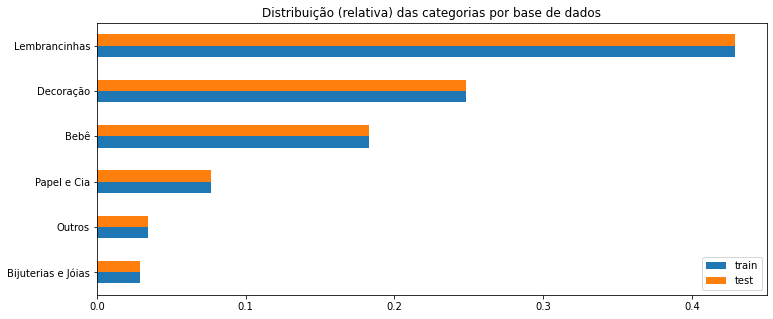

In [27]:
# verificando se a separação manteve a distribuição das categorias nos dados
(train_prod_df["category"].
 value_counts(ascending=True, normalize=True).
 to_frame("train").
 join(test_prod_df["category"].
      value_counts(ascending=True, normalize=True).
      to_frame("test"))
 ).plot(kind="barh", figsize=(12, 5), title="Distribuição (relativa) das categorias por base de dados")
plt.show()

## Query

Para o salvamento dos dadas de query a separação será simples.

In [28]:
train_query_df, test_query_df = train_test_split(df,
                                                 test_size=0.3,
                                                 random_state=23)
for filename, data in [("train_query.pickle", train_query_df),
                       ("test_query.pickle", test_query_df)]:
    data.to_pickle("../data/" + filename)